# Initial codes

This notebook illustrates how Bayesian inference can be used to infer response rates of each group (basket) in a Basket trial.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import numpy as np
import pandas as pd
import arviz as az

In [4]:
from pyBasket.env import Trial
from pyBasket.common import DEFAULT_EFFICACY_CUTOFF, DEFAULT_FUTILITY_CUTOFF

In [5]:
DEBUG = True

In [6]:
num_burn_in = 1E5
num_posterior_samples = 1E5
num_chains = None # let pymc decide

In [7]:
if DEBUG:
    num_burn_in = 5E4
    num_posterior_samples = 5E4
    num_chains = 1

## Example 1: treatment is of interest in all groups

Same example as in [Berry et al. 2013](https://journals.sagepub.com/doi/full/10.1177/1740774513497539) (Figure 1).

4 groups are present in the trial, and all group response rates to the treatment are the same (0.3). The trial enrolls patients in 6 stages, first taking 10 patient for each group in the first stage, followed by 5 patients for each group in latter stages.

> The first example is a scenario in which responses are simulated assuming p = 30% in all four groups. This example illustrates the effect of borrowing across groups when all groups are similar, such as the smoothing of the observed response rates and a reduction in uncertainty.

### Generate data

In [8]:
K = 4    # the number of groups
p0 = 0.1 # null response rate
p1 = 0.3 # target response rate

true_response_rates = [p1, p1, p1, p1]
enrollment = [10, 5, 5, 5, 5, 5]

evaluate_interim = [True, True, True, True, True, True] # evaluate every interim stage
analysis_names = ['independent', 'hierarchical', 'bhm']

In [9]:
futility_cutoff = DEFAULT_FUTILITY_CUTOFF
efficacy_cutoff = DEFAULT_EFFICACY_CUTOFF
early_futility_stop = False
early_efficacy_stop = False

In [10]:
trial = Trial(K, p0, p1, enrollment, evaluate_interim, 
              num_burn_in, num_posterior_samples, analysis_names, 
              true_response_rates=true_response_rates,
              futility_cutoff=futility_cutoff, efficacy_cutoff=efficacy_cutoff,
              early_futility_stop=early_futility_stop,
              early_efficacy_stop=early_efficacy_stop,              
              num_chains=num_chains)

done = trial.reset()
while not done:
    done = trial.step()


########## Stage=0 Enrolled = 10 ##########

Analysis independent Group 0 (OPEN): 2/10
Analysis hierarchical Group 0 (OPEN): 2/10
Analysis bhm Group 0 (OPEN): 2/10

Analysis independent Group 1 (OPEN): 3/10
Analysis hierarchical Group 1 (OPEN): 3/10
Analysis bhm Group 1 (OPEN): 3/10

Analysis independent Group 2 (OPEN): 1/10
Analysis hierarchical Group 2 (OPEN): 1/10
Analysis bhm Group 2 (OPEN): 1/10

Analysis independent Group 3 (OPEN): 1/10
Analysis hierarchical Group 3 (OPEN): 1/10
Analysis bhm Group 3 (OPEN): 1/10

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 35 seconds.


,prob,futile,effective
k,,,
0,0.61912,False,False
1,0.84022,False,False
2,0.31764,False,False
3,0.32540,False,False


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 88 seconds.


,prob,futile,effective
k,,,
0,0.61252,False,False
1,0.76262,False,False
2,0.43446,False,False
3,0.43594,False,False


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 68 seconds.


,prob,futile,effective
k,,,
0,0.51166,False,False
1,0.78642,False,False
2,0.20658,False,False
3,0.20332,False,False



########## Stage=1 Enrolled = 15 ##########

Analysis independent Group 0 (OPEN): 2/15
Analysis hierarchical Group 0 (OPEN): 2/15
Analysis bhm Group 0 (OPEN): 2/15

Analysis independent Group 1 (OPEN): 4/15
Analysis hierarchical Group 1 (OPEN): 4/15
Analysis bhm Group 1 (OPEN): 4/15

Analysis independent Group 2 (OPEN): 2/15
Analysis hierarchical Group 2 (OPEN): 2/15
Analysis bhm Group 2 (OPEN): 2/15

Analysis independent Group 3 (OPEN): 2/15
Analysis hierarchical Group 3 (OPEN): 2/15
Analysis bhm Group 3 (OPEN): 2/15

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 36 seconds.


,prob,futile,effective
k,,,
0,0.35118,False,False
1,0.79822,False,False
2,0.35104,False,False
3,0.35164,False,False


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 81 seconds.


,prob,futile,effective
k,,,
0,0.40224,False,False
1,0.71858,False,False
2,0.39990,False,False
3,0.40282,False,False


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 64 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,prob,futile,effective
k,,,
0,0.25918,False,False
1,0.74284,False,False
2,0.25798,False,False
3,0.25888,False,False



########## Stage=2 Enrolled = 20 ##########

Analysis independent Group 0 (OPEN): 3/20
Analysis hierarchical Group 0 (OPEN): 3/20
Analysis bhm Group 0 (OPEN): 3/20

Analysis independent Group 1 (OPEN): 6/20
Analysis hierarchical Group 1 (OPEN): 6/20
Analysis bhm Group 1 (OPEN): 6/20

Analysis independent Group 2 (OPEN): 4/20
Analysis hierarchical Group 2 (OPEN): 4/20
Analysis bhm Group 2 (OPEN): 4/20

Analysis independent Group 3 (OPEN): 5/20
Analysis hierarchical Group 3 (OPEN): 5/20
Analysis bhm Group 3 (OPEN): 5/20

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 34 seconds.


,prob,futile,effective
k,,,
0,0.36814,False,False
1,0.89012,False,False
2,0.58810,False,False
3,0.77138,False,False


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 82 seconds.


,prob,futile,effective
k,,,
0,0.51288,False,False
1,0.87774,False,False
2,0.66214,False,False
3,0.78778,False,False


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 63 seconds.


,prob,futile,effective
k,,,
0,0.30174,False,False
1,0.86674,False,False
2,0.52456,False,False
3,0.72656,False,False



########## Stage=3 Enrolled = 25 ##########

Analysis independent Group 0 (OPEN): 7/25
Analysis hierarchical Group 0 (OPEN): 7/25
Analysis bhm Group 0 (OPEN): 7/25

Analysis independent Group 1 (OPEN): 8/25
Analysis hierarchical Group 1 (OPEN): 8/25
Analysis bhm Group 1 (OPEN): 8/25

Analysis independent Group 2 (OPEN): 6/25
Analysis hierarchical Group 2 (OPEN): 6/25
Analysis bhm Group 2 (OPEN): 6/25

Analysis independent Group 3 (OPEN): 6/25
Analysis hierarchical Group 3 (OPEN): 6/25
Analysis bhm Group 3 (OPEN): 6/25

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 34 seconds.


,prob,futile,effective
k,,,
0,0.86902,False,False
1,0.93904,False,True
2,0.75272,False,False
3,0.74958,False,False


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 84 seconds.


,prob,futile,effective
k,,,
0,0.90018,False,True
1,0.94914,False,True
2,0.82756,False,False
3,0.83190,False,False


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 61 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,prob,futile,effective
k,,,
0,0.84820,False,False
1,0.93092,False,True
2,0.71462,False,False
3,0.71344,False,False



########## Stage=4 Enrolled = 30 ##########

Analysis independent Group 0 (OPEN): 8/30
Analysis hierarchical Group 0 (OPEN): 8/30
Analysis bhm Group 0 (OPEN): 8/30

Analysis independent Group 1 (OPEN): 10/30
Analysis hierarchical Group 1 (OPEN): 10/30
Analysis bhm Group 1 (OPEN): 10/30

Analysis independent Group 2 (OPEN): 7/30
Analysis hierarchical Group 2 (OPEN): 7/30
Analysis bhm Group 2 (OPEN): 7/30

Analysis independent Group 3 (OPEN): 8/30
Analysis hierarchical Group 3 (OPEN): 8/30
Analysis bhm Group 3 (OPEN): 8/30

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 33 seconds.


,prob,futile,effective
k,,,
0,0.84984,False,False
1,0.96696,False,True
2,0.73370,False,False
3,0.84902,False,False


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 83 seconds.


,prob,futile,effective
k,,,
0,0.89472,False,False
1,0.97036,False,True
2,0.82006,False,False
3,0.89534,False,False


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 59 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,prob,futile,effective
k,,,
0,0.82882,False,False
1,0.96126,False,True
2,0.69680,False,False
3,0.82716,False,False



########## Stage=5 Enrolled = 35 ##########

Analysis independent Group 0 (OPEN): 10/35
Analysis hierarchical Group 0 (OPEN): 10/35
Analysis bhm Group 0 (OPEN): 10/35

Analysis independent Group 1 (OPEN): 13/35
Analysis hierarchical Group 1 (OPEN): 13/35
Analysis bhm Group 1 (OPEN): 13/35

Analysis independent Group 2 (OPEN): 8/35
Analysis hierarchical Group 2 (OPEN): 8/35
Analysis bhm Group 2 (OPEN): 8/35

Analysis independent Group 3 (OPEN): 9/35
Analysis hierarchical Group 3 (OPEN): 9/35
Analysis bhm Group 3 (OPEN): 9/35

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 33 seconds.


,prob,futile,effective
k,,,
0,0.99952,None,True
1,0.99998,None,True
2,0.99254,None,True
3,0.99816,None,True


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 82 seconds.


,prob,futile,effective
k,,,
0,0.99982,None,True
1,1.00000,None,True
2,0.99836,None,True
3,0.99956,None,True


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 60 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,prob,futile,effective
k,,,
0,0.99932,None,True
1,1.00000,None,True
2,0.98808,None,True
3,0.99682,None,True


### Check last results

### Independent

In [11]:
analysis_name = analysis_names[0]
analysis_name

'independent'

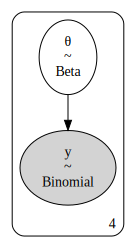

In [12]:
trial.visualise_model(analysis_name)

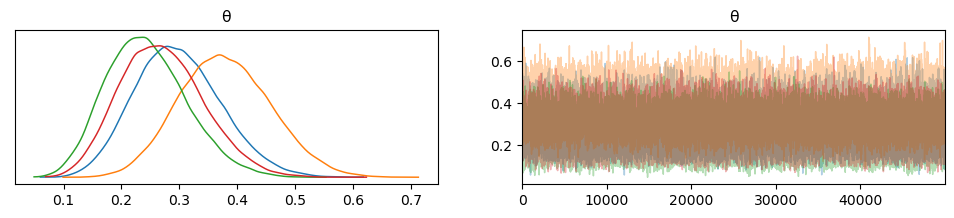

In [13]:
trial.plot_trace(analysis_name, -1)

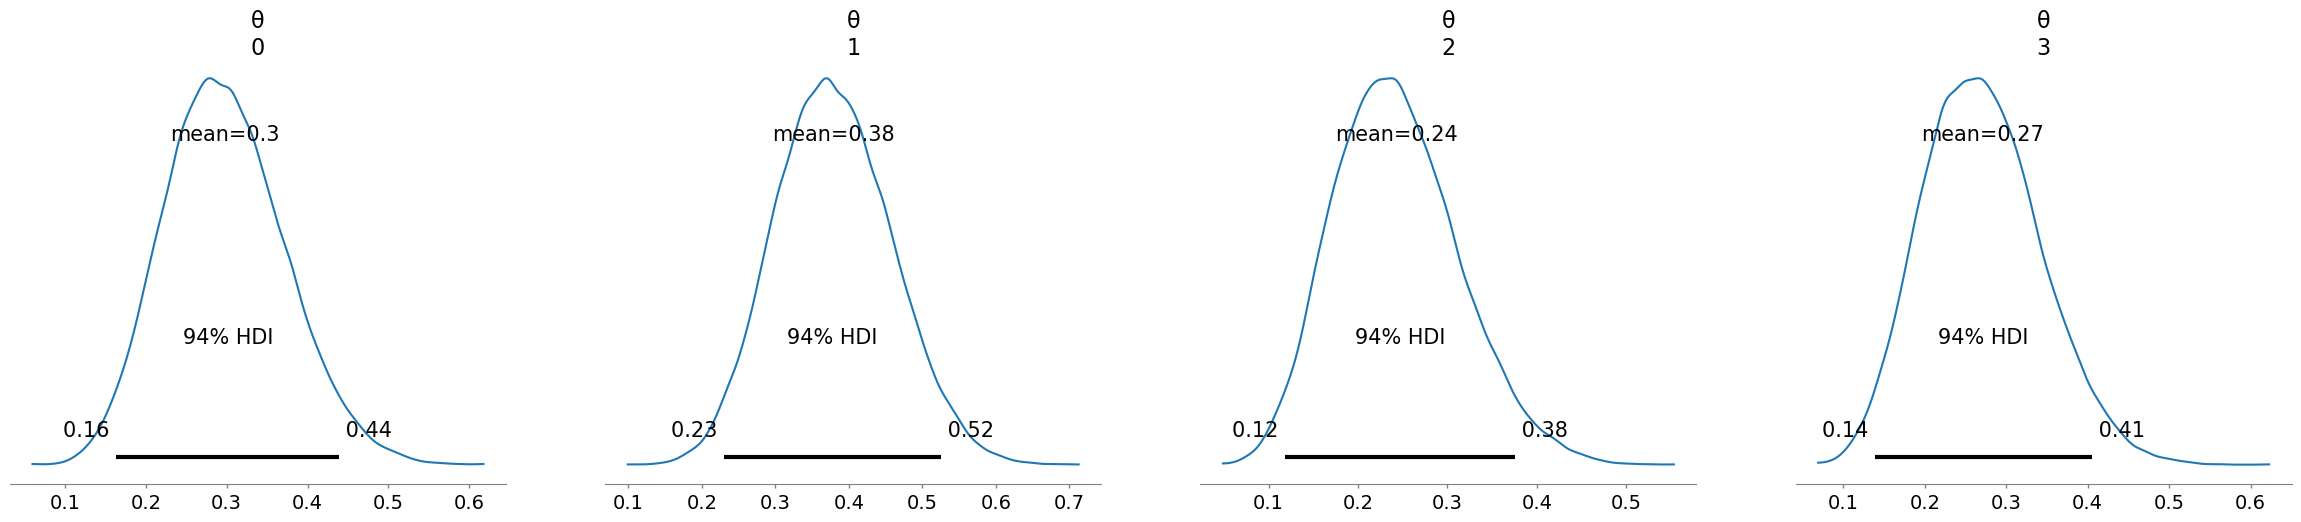

In [14]:
trial.plot_posterior(analysis_name, -1)

In [15]:
trial.final_report(analysis_name)

,status,nnz,total
k,,,
0,COMPLETED_EFFECTIVE,10,35
1,COMPLETED_EFFECTIVE,13,35
2,COMPLETED_EFFECTIVE,8,35
3,COMPLETED_EFFECTIVE,9,35


### Hierarchical

In [16]:
analysis_name = analysis_names[1]
analysis_name

'hierarchical'

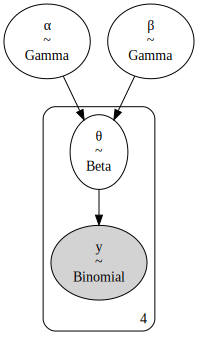

In [17]:
trial.visualise_model(analysis_name)

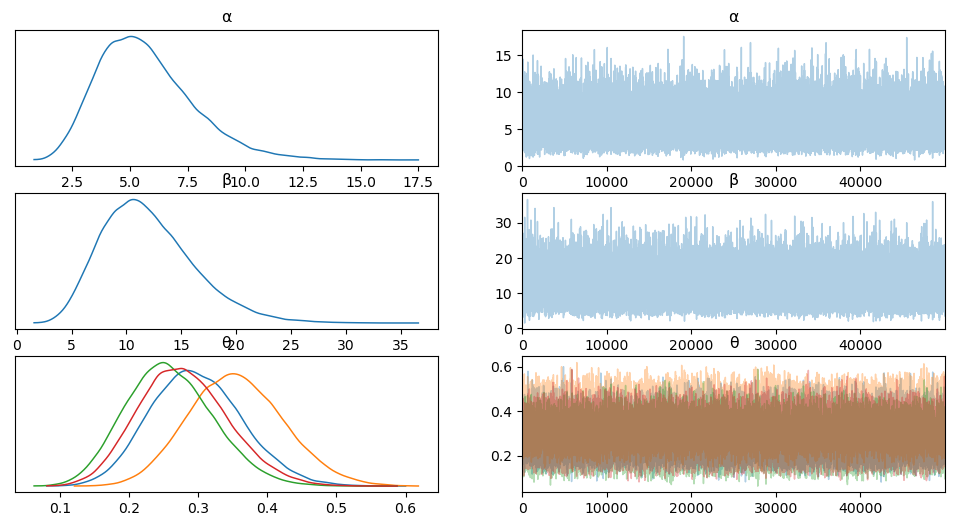

In [18]:
trial.plot_trace(analysis_name, -1)

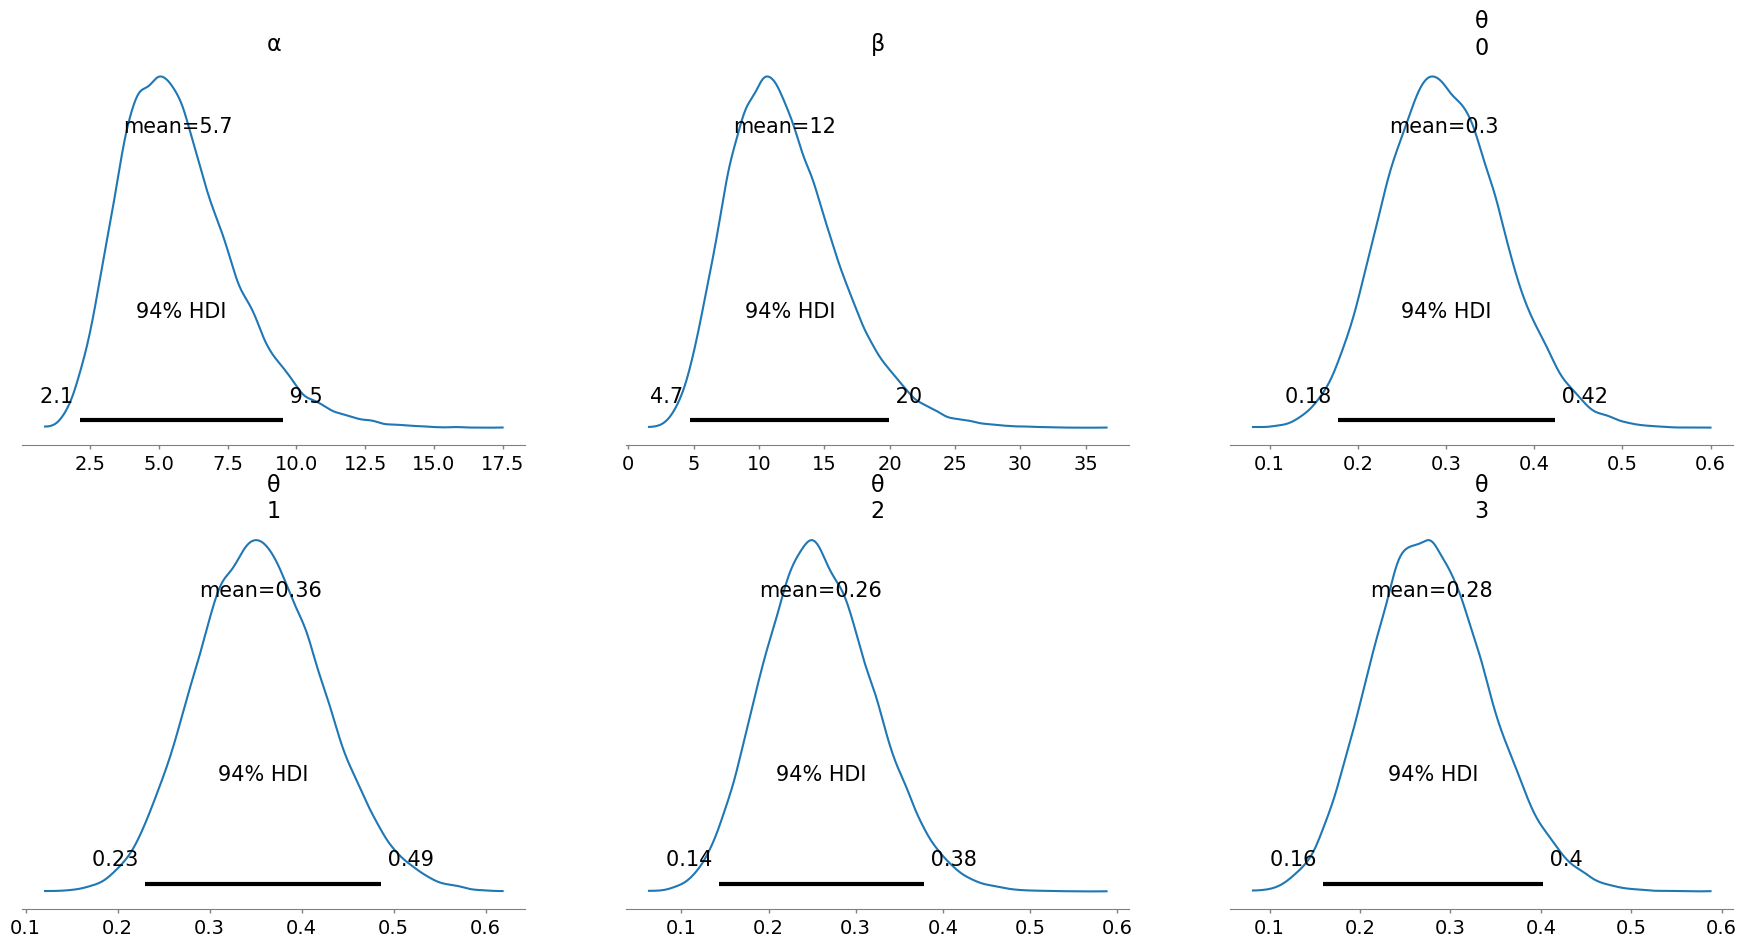

In [19]:
trial.plot_posterior(analysis_name, -1)

In [20]:
trial.final_report(analysis_name)

,status,nnz,total
k,,,
0,COMPLETED_EFFECTIVE,10,35
1,COMPLETED_EFFECTIVE,13,35
2,COMPLETED_EFFECTIVE,8,35
3,COMPLETED_EFFECTIVE,9,35


### BHM

In [21]:
analysis_name = analysis_names[2]
analysis_name

'bhm'

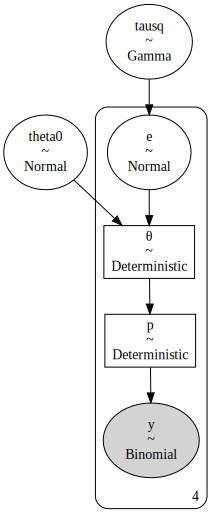

In [22]:
trial.visualise_model(analysis_name)

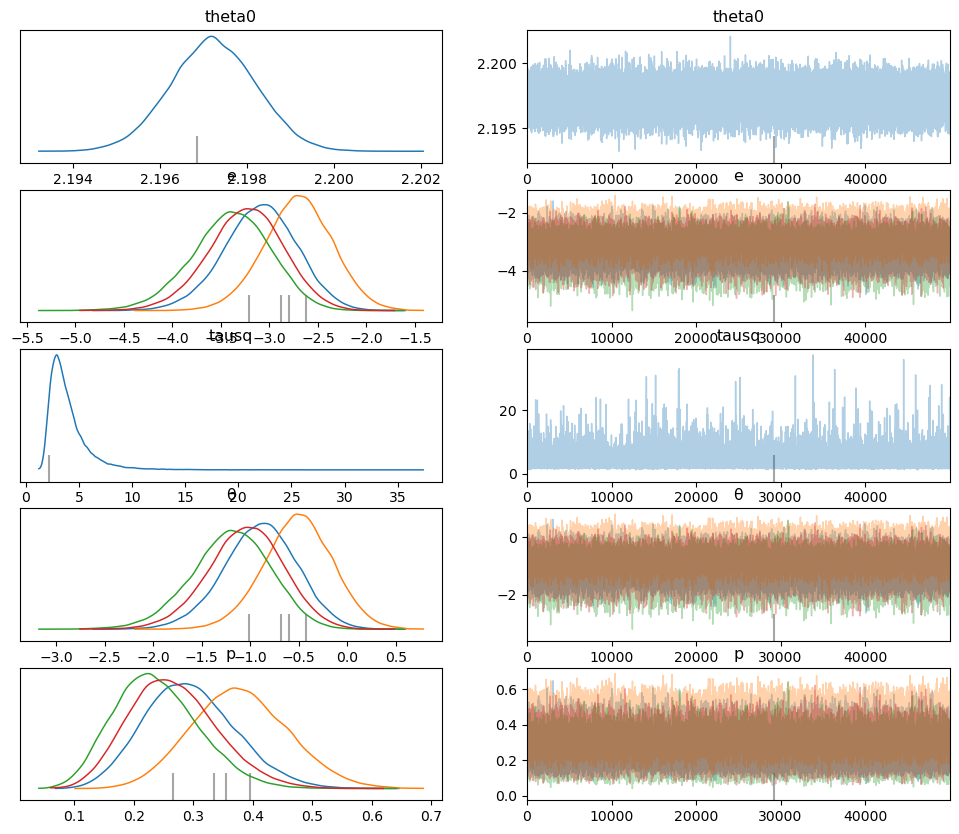

In [23]:
trial.plot_trace(analysis_name, -1)

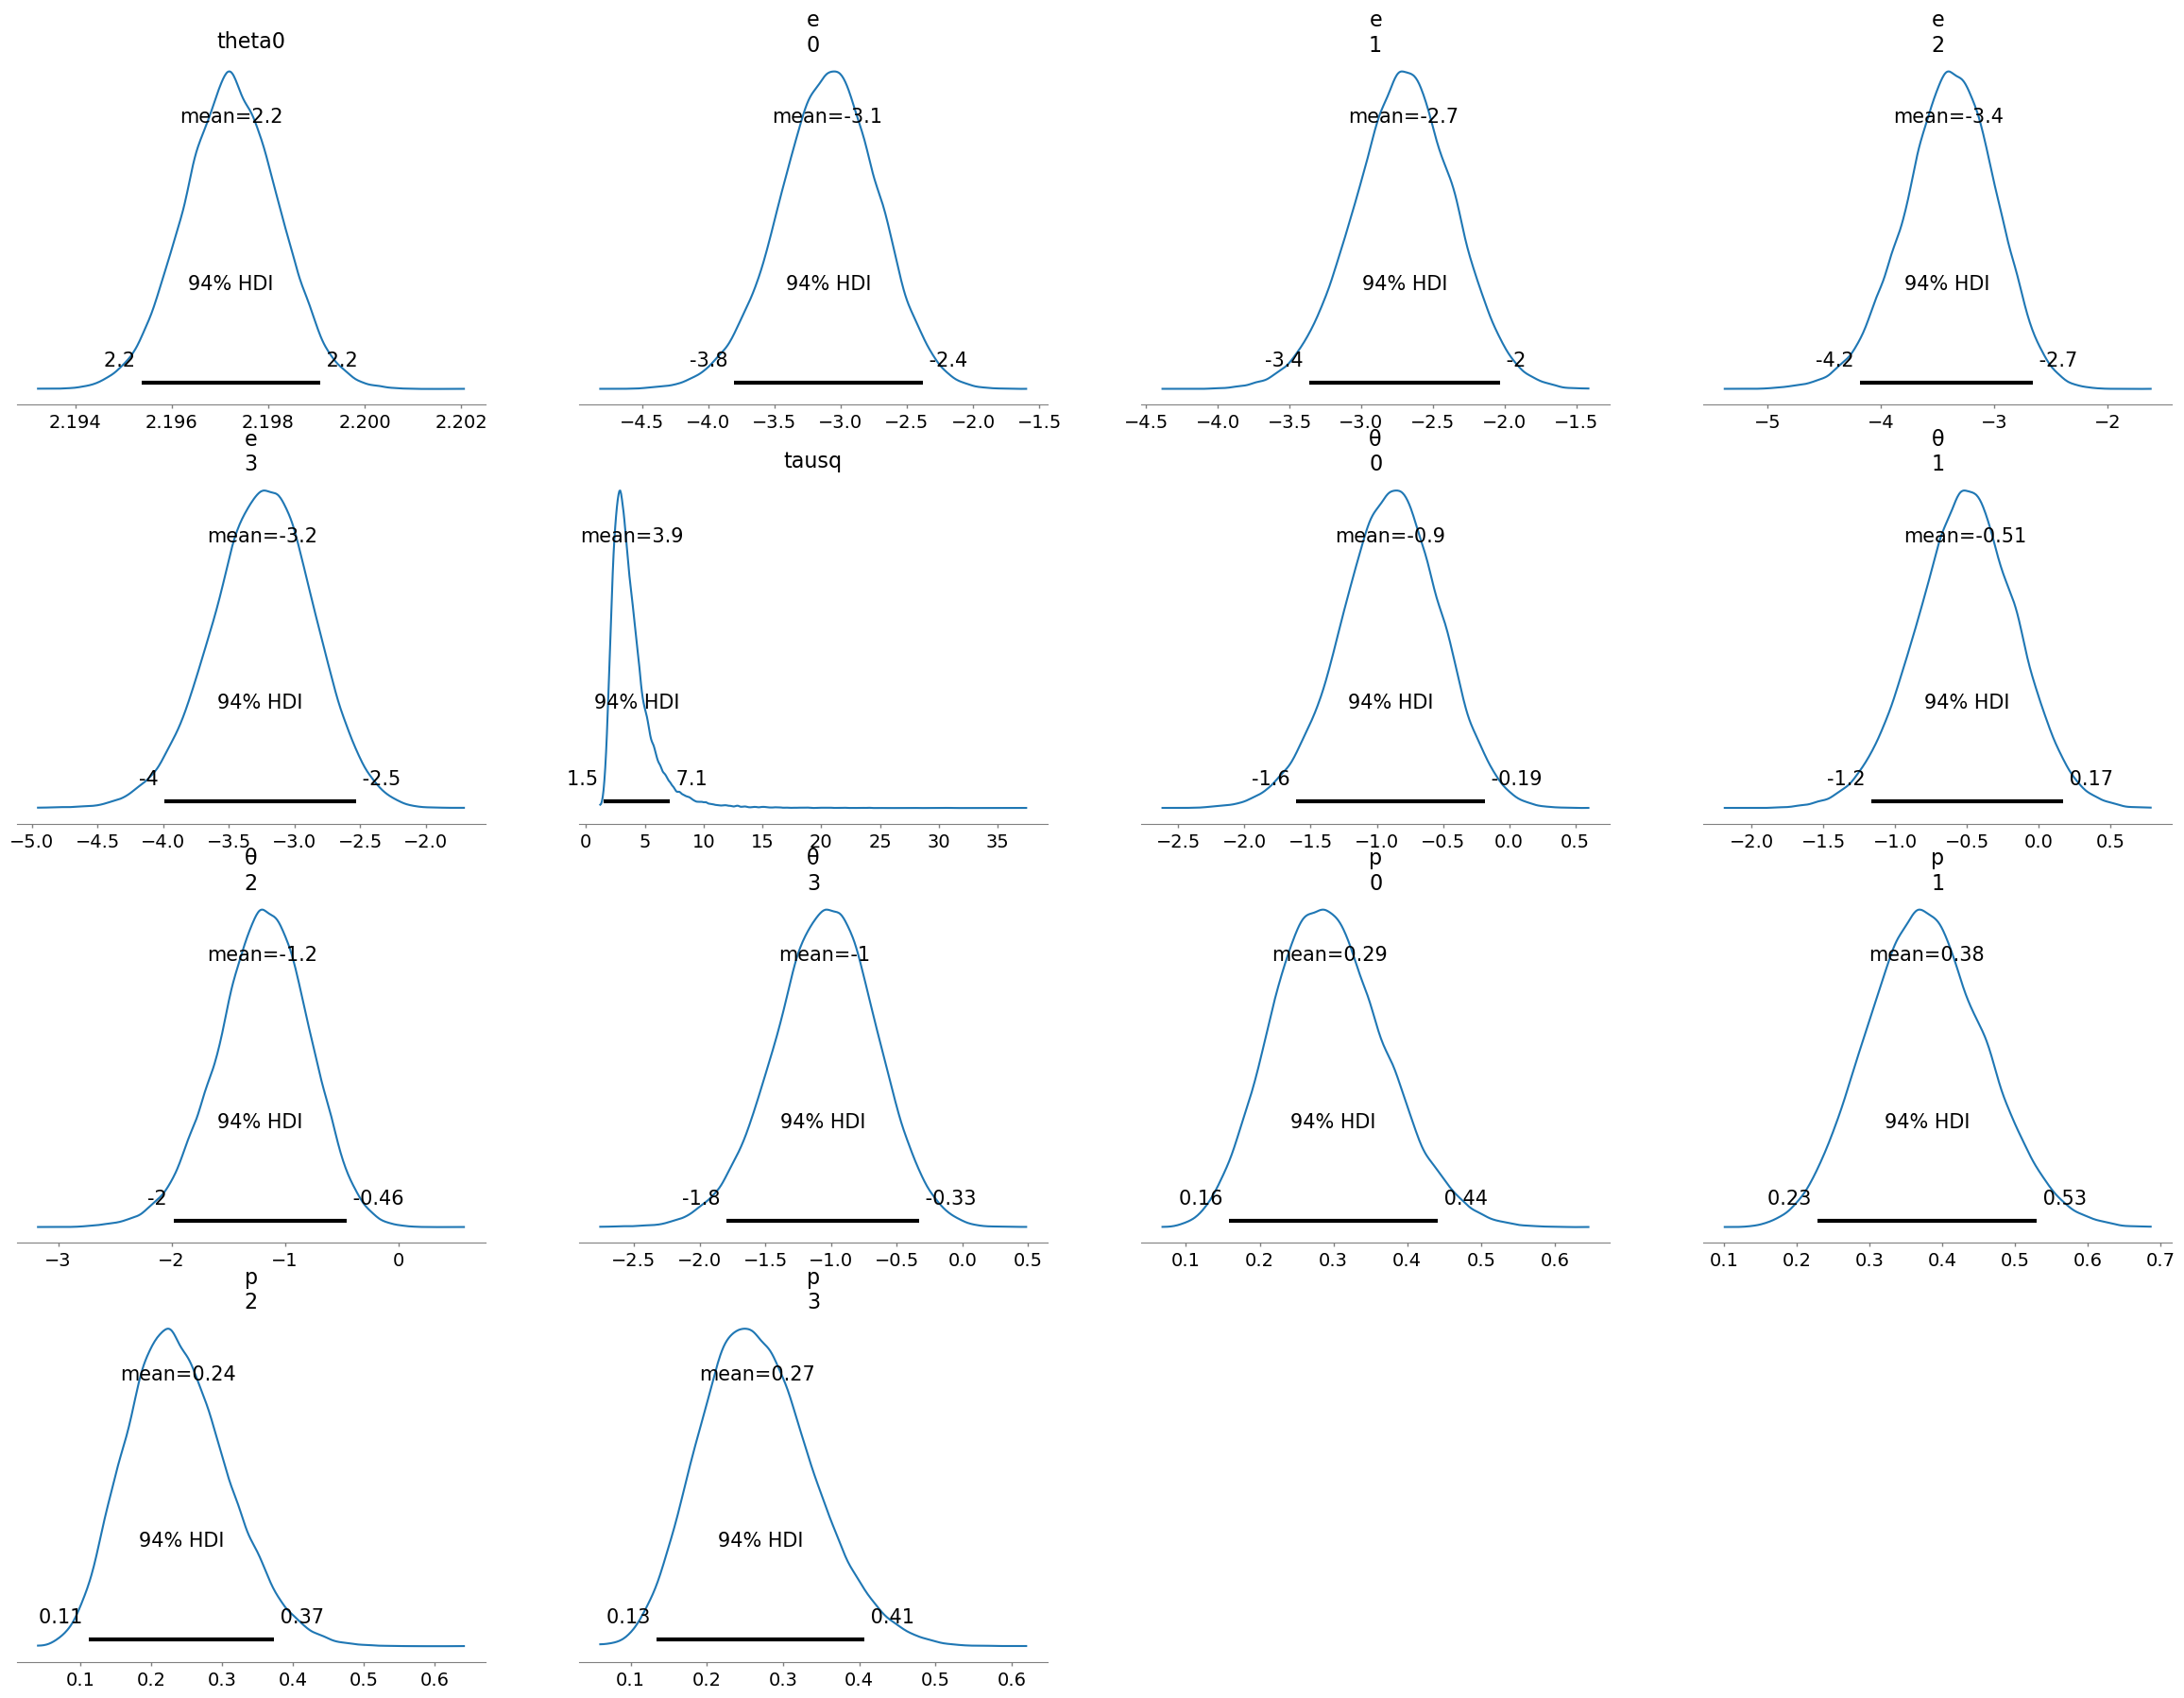

In [24]:
trial.plot_posterior(analysis_name, -1)

In [25]:
trial.final_report(analysis_name)

,status,nnz,total
k,,,
0,COMPLETED_EFFECTIVE,10,35
1,COMPLETED_EFFECTIVE,13,35
2,COMPLETED_EFFECTIVE,8,35
3,COMPLETED_EFFECTIVE,9,35


## Example 2: treatment is of interest in only two groups

Same example as in [Berry et al. 2013](https://journals.sagepub.com/doi/full/10.1177/1740774513497539) (Figure 2).

4 groups are present in the group, with first two group responses = 0.10 and the other two groups = 0.3. The trial enrolls patients in 6 stages, first taking 10 patient for each group in the first stage, followed by 5 patients for each group in latter stages.

> The second example is from a scenario in which responses are simulated assuming p = 10% in two groups and p = 30% in two groups. This example illustrates the effect of borrowing, and that the harm is not great, when groups are dissimilar.

### Generate data

In [26]:
K = 4    # the number of groups
p0 = 0.1 # null response rate
p1 = 0.3 # target response rate

true_response_rates = [p0, p0, p1, p1]
enrollment = [10, 5, 5, 5, 5, 5]

evaluate_interim = [True, True, True, True, True, True] # evaluate every interim stage
analysis_names = ['independent', 'hierarchical', 'bhm']

In [27]:
futility_cutoff = DEFAULT_FUTILITY_CUTOFF
efficacy_cutoff = DEFAULT_EFFICACY_CUTOFF
early_futility_stop = True
early_efficacy_stop = True

In [28]:
trial = Trial(K, p0, p1, enrollment, evaluate_interim, 
              num_burn_in, num_posterior_samples, analysis_names, 
              true_response_rates=true_response_rates,
              futility_cutoff=futility_cutoff, efficacy_cutoff=efficacy_cutoff,
              early_futility_stop=early_futility_stop,
              early_efficacy_stop=early_efficacy_stop,              
              num_chains=num_chains)

done = trial.reset()
while not done:
    done = trial.step()


########## Stage=0 Enrolled = 10 ##########

Analysis independent Group 0 (OPEN): 0/10
Analysis hierarchical Group 0 (OPEN): 0/10
Analysis bhm Group 0 (OPEN): 0/10

Analysis independent Group 1 (OPEN): 0/10
Analysis hierarchical Group 1 (OPEN): 0/10
Analysis bhm Group 1 (OPEN): 0/10

Analysis independent Group 2 (OPEN): 2/10
Analysis hierarchical Group 2 (OPEN): 2/10
Analysis bhm Group 2 (OPEN): 2/10

Analysis independent Group 3 (OPEN): 1/10
Analysis hierarchical Group 3 (OPEN): 1/10
Analysis bhm Group 3 (OPEN): 1/10

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 42 seconds.


,prob,futile,effective
k,,,
0,0.08494,False,False
1,0.08796,False,False
2,0.61482,False,False
3,0.31950,False,False


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 88 seconds.


,prob,futile,effective
k,,,
0,0.09672,False,False
1,0.09674,False,False
2,0.38414,False,False
3,0.21266,False,False


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 195 seconds.


,prob,futile,effective
k,,,
0,0.00758,True,False
1,0.00678,True,False
2,0.45044,False,False
3,0.15220,False,False



########## Stage=1 Enrolled = 15 ##########

Analysis independent Group 0 (OPEN): 0/15
Analysis hierarchical Group 0 (OPEN): 0/15
Analysis bhm Group 0 (EARLY_STOP_FUTILE): 0/10

Analysis independent Group 1 (OPEN): 0/15
Analysis hierarchical Group 1 (OPEN): 0/15
Analysis bhm Group 1 (EARLY_STOP_FUTILE): 0/10

Analysis independent Group 2 (OPEN): 4/15
Analysis hierarchical Group 2 (OPEN): 4/15
Analysis bhm Group 2 (OPEN): 4/15

Analysis independent Group 3 (OPEN): 2/15
Analysis hierarchical Group 3 (OPEN): 2/15
Analysis bhm Group 3 (OPEN): 2/15

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 44 seconds.


,prob,futile,effective
k,,,
0,0.02724,True,False
1,0.02808,True,False
2,0.79922,False,False
3,0.35192,False,False


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 88 seconds.


,prob,futile,effective
k,,,
0,0.04002,True,False
1,0.04226,True,False
2,0.56308,False,False
3,0.22678,False,False


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 228 seconds.
The acceptance probability does not match the target. It is 0.9659, but should be close to 0.8. Try to increase the number of tuning steps.


,prob,futile,effective
k,,,
0,0.00836,True,False
1,0.00788,True,False
2,0.70780,False,False
3,0.21100,False,False



########## Stage=2 Enrolled = 20 ##########

Analysis independent Group 0 (EARLY_STOP_FUTILE): 0/15
Analysis hierarchical Group 0 (EARLY_STOP_FUTILE): 0/15
Analysis bhm Group 0 (EARLY_STOP_FUTILE): 0/10

Analysis independent Group 1 (EARLY_STOP_FUTILE): 0/15
Analysis hierarchical Group 1 (EARLY_STOP_FUTILE): 0/15
Analysis bhm Group 1 (EARLY_STOP_FUTILE): 0/10

Analysis independent Group 2 (OPEN): 5/20
Analysis hierarchical Group 2 (OPEN): 5/20
Analysis bhm Group 2 (OPEN): 5/20

Analysis independent Group 3 (OPEN): 5/20
Analysis hierarchical Group 3 (OPEN): 5/20
Analysis bhm Group 3 (OPEN): 5/20

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 42 seconds.


,prob,futile,effective
k,,,
0,0.02784,True,False
1,0.02730,True,False
2,0.76958,False,False
3,0.77124,False,False


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 85 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


,prob,futile,effective
k,,,
0,0.05912,False,False
1,0.05902,False,False
2,0.60752,False,False
3,0.60864,False,False


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 200 seconds.
The acceptance probability does not match the target. It is 0.9614, but should be close to 0.8. Try to increase the number of tuning steps.


,prob,futile,effective
k,,,
0,0.00956,True,False
1,0.00874,True,False
2,0.68750,False,False
3,0.68708,False,False



########## Stage=3 Enrolled = 25 ##########

Analysis independent Group 0 (EARLY_STOP_FUTILE): 0/15
Analysis hierarchical Group 0 (EARLY_STOP_FUTILE): 0/15
Analysis bhm Group 0 (EARLY_STOP_FUTILE): 0/10

Analysis independent Group 1 (EARLY_STOP_FUTILE): 0/15
Analysis hierarchical Group 1 (EARLY_STOP_FUTILE): 0/15
Analysis bhm Group 1 (EARLY_STOP_FUTILE): 0/10

Analysis independent Group 2 (OPEN): 5/25
Analysis hierarchical Group 2 (OPEN): 5/25
Analysis bhm Group 2 (OPEN): 5/25

Analysis independent Group 3 (OPEN): 7/25
Analysis hierarchical Group 3 (OPEN): 7/25
Analysis bhm Group 3 (OPEN): 7/25

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 44 seconds.


,prob,futile,effective
k,,,
0,0.02740,True,False
1,0.02820,True,False
2,0.57914,False,False
3,0.87184,False,False


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 85 seconds.


,prob,futile,effective
k,,,
0,0.05654,False,False
1,0.05614,False,False
2,0.44474,False,False
3,0.73280,False,False


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 172 seconds.
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6403, but should be close to 0.8. Try to increase the number of tuning steps.


,prob,futile,effective
k,,,
0,0.00992,True,False
1,0.00842,True,False
2,0.47146,False,False
3,0.82154,False,False



########## Stage=4 Enrolled = 30 ##########

Analysis independent Group 0 (EARLY_STOP_FUTILE): 0/15
Analysis hierarchical Group 0 (EARLY_STOP_FUTILE): 0/15
Analysis bhm Group 0 (EARLY_STOP_FUTILE): 0/10

Analysis independent Group 1 (EARLY_STOP_FUTILE): 0/15
Analysis hierarchical Group 1 (EARLY_STOP_FUTILE): 0/15
Analysis bhm Group 1 (EARLY_STOP_FUTILE): 0/10

Analysis independent Group 2 (OPEN): 6/30
Analysis hierarchical Group 2 (OPEN): 6/30
Analysis bhm Group 2 (OPEN): 6/30

Analysis independent Group 3 (OPEN): 9/30
Analysis hierarchical Group 3 (OPEN): 9/30
Analysis bhm Group 3 (OPEN): 9/30

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 43 seconds.


,prob,futile,effective
k,,,
0,0.02858,True,False
1,0.02794,True,False
2,0.56988,False,False
3,0.92726,False,True


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 84 seconds.


,prob,futile,effective
k,,,
0,0.05944,False,False
1,0.06018,False,False
2,0.45498,False,False
3,0.82798,False,False


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 217 seconds.
The acceptance probability does not match the target. It is 0.962, but should be close to 0.8. Try to increase the number of tuning steps.


,prob,futile,effective
k,,,
0,0.00928,True,False
1,0.00850,True,False
2,0.47704,False,False
3,0.89818,False,False



########## Stage=5 Enrolled = 35 ##########

Analysis independent Group 0 (EARLY_STOP_FUTILE): 0/15
Analysis hierarchical Group 0 (EARLY_STOP_FUTILE): 0/15
Analysis bhm Group 0 (EARLY_STOP_FUTILE): 0/10

Analysis independent Group 1 (EARLY_STOP_FUTILE): 0/15
Analysis hierarchical Group 1 (EARLY_STOP_FUTILE): 0/15
Analysis bhm Group 1 (EARLY_STOP_FUTILE): 0/10

Analysis independent Group 2 (OPEN): 8/35
Analysis hierarchical Group 2 (OPEN): 8/35
Analysis bhm Group 2 (OPEN): 8/35

Analysis independent Group 3 (EARLY_STOP_EFFECTIVE): 9/30
Analysis hierarchical Group 3 (OPEN): 9/35
Analysis bhm Group 3 (OPEN): 9/35

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 44 seconds.


,prob,futile,effective
k,,,
0,0.18516,None,False
1,0.18636,None,False
2,0.99220,None,True
3,0.99950,None,True


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 86 seconds.


,prob,futile,effective
k,,,
0,0.38814,None,False
1,0.38646,None,False
2,0.98726,None,True
3,0.99564,None,True


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 212 seconds.
The acceptance probability does not match the target. It is 0.9575, but should be close to 0.8. Try to increase the number of tuning steps.


,prob,futile,effective
k,,,
0,0.04178,None,False
1,0.04324,None,False
2,0.98496,None,True
3,0.99600,None,True


### Check last results

### Independent

In [29]:
analysis_name = analysis_names[0]
analysis_name

'independent'

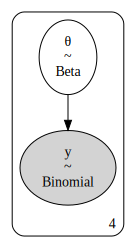

In [30]:
trial.visualise_model(analysis_name)

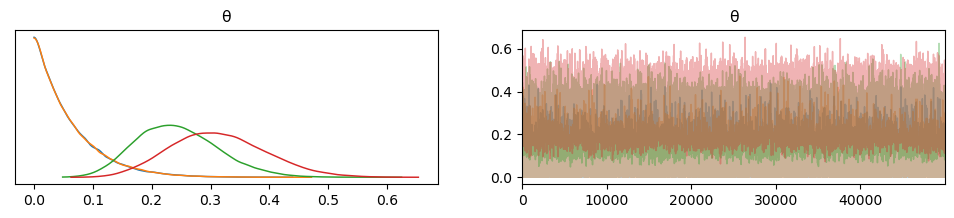

In [31]:
trial.plot_trace(analysis_name, -1)

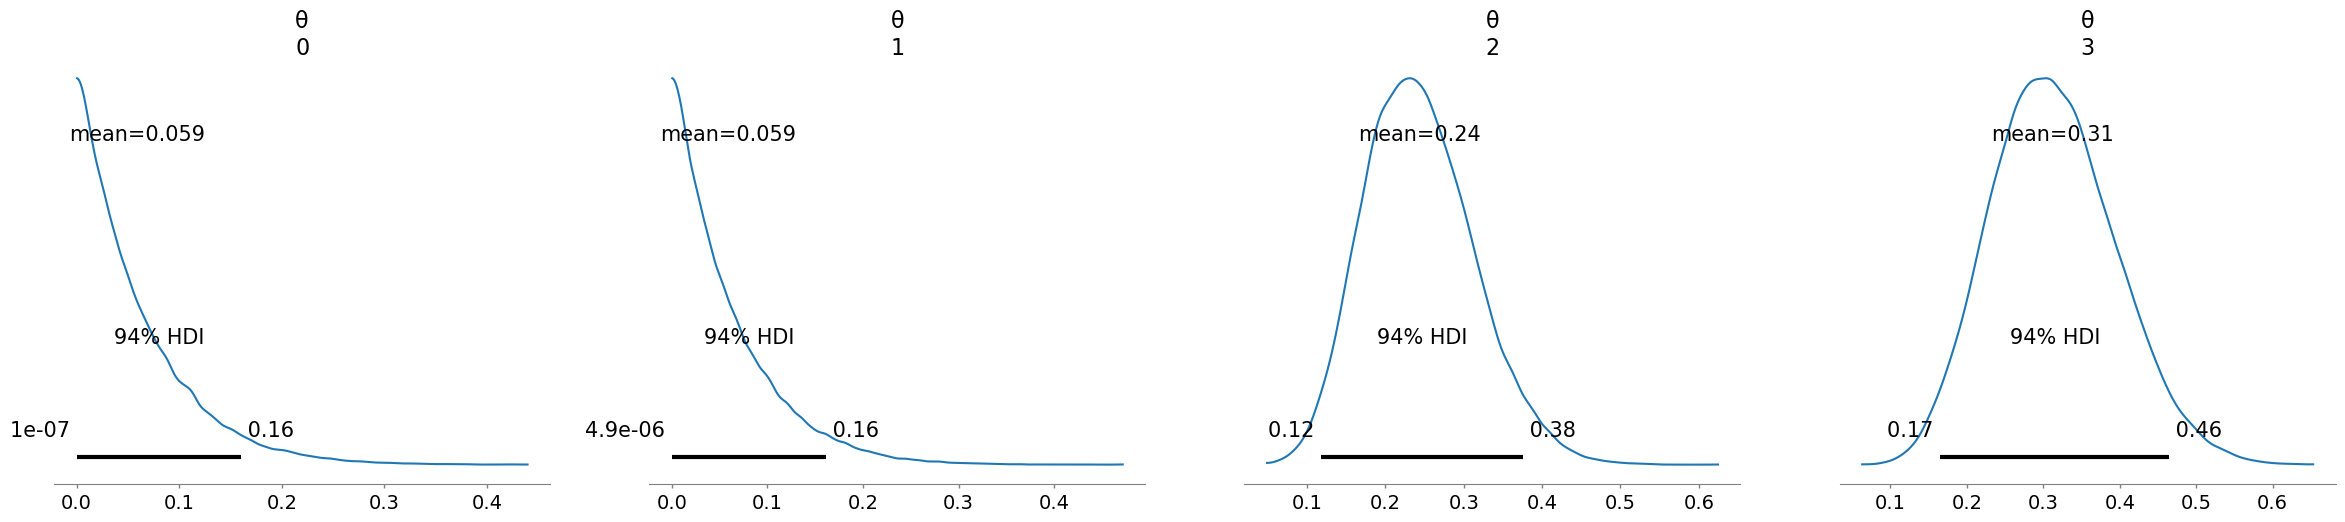

In [32]:
trial.plot_posterior(analysis_name, -1)

In [33]:
trial.final_report(analysis_name)

,status,nnz,total
k,,,
0,EARLY_STOP_FUTILE,0,15
1,EARLY_STOP_FUTILE,0,15
2,COMPLETED_EFFECTIVE,8,35
3,EARLY_STOP_EFFECTIVE,9,30


### Hierarchical

In [34]:
analysis_name = analysis_names[1]
analysis_name

'hierarchical'

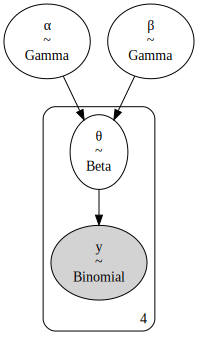

In [35]:
trial.visualise_model(analysis_name)

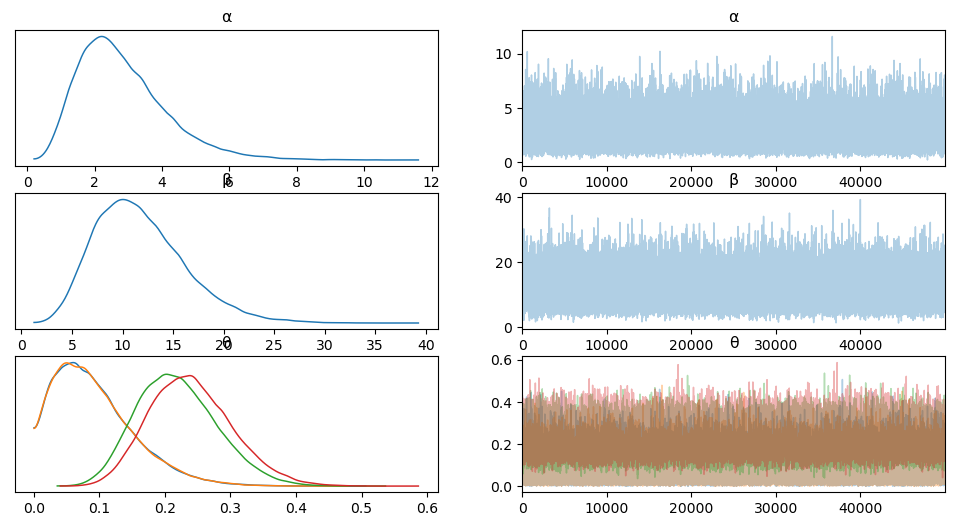

In [36]:
trial.plot_trace(analysis_name, -1)

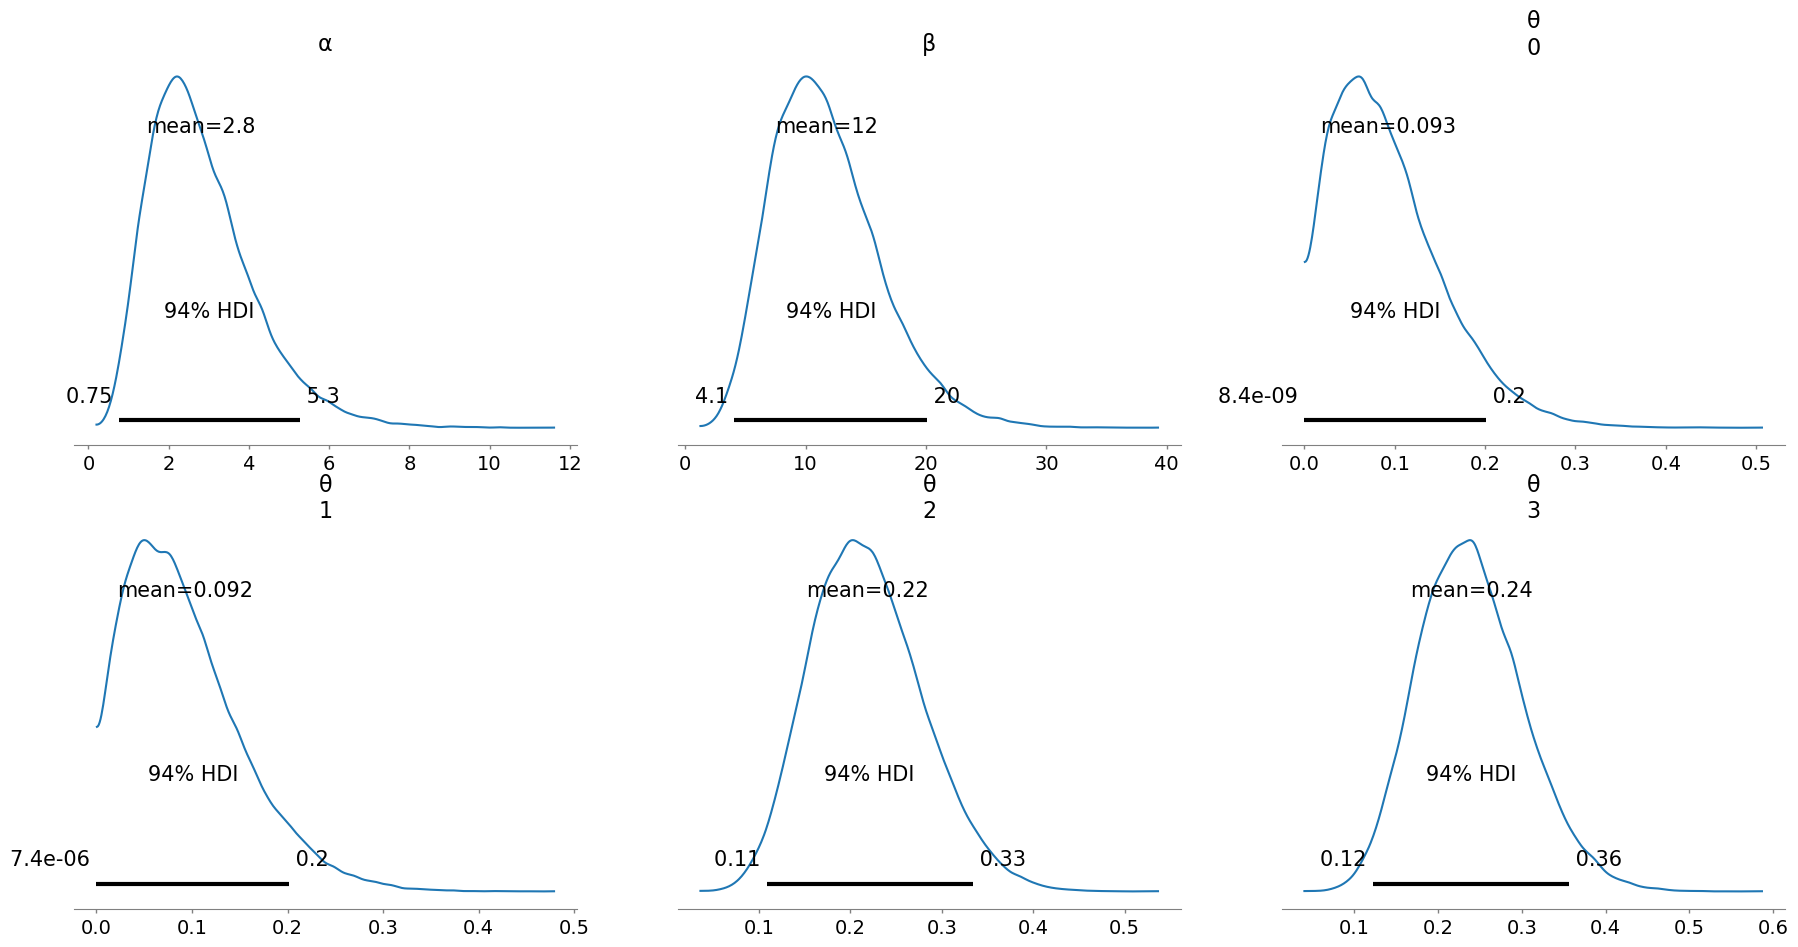

In [37]:
trial.plot_posterior(analysis_name, -1)

In [38]:
trial.final_report(analysis_name)

,status,nnz,total
k,,,
0,EARLY_STOP_FUTILE,0,15
1,EARLY_STOP_FUTILE,0,15
2,COMPLETED_EFFECTIVE,8,35
3,COMPLETED_EFFECTIVE,9,35


### BHM

In [39]:
analysis_name = analysis_names[2]
analysis_name

'bhm'

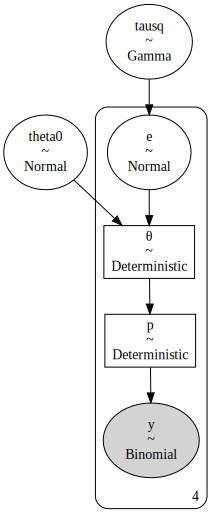

In [40]:
trial.visualise_model(analysis_name)

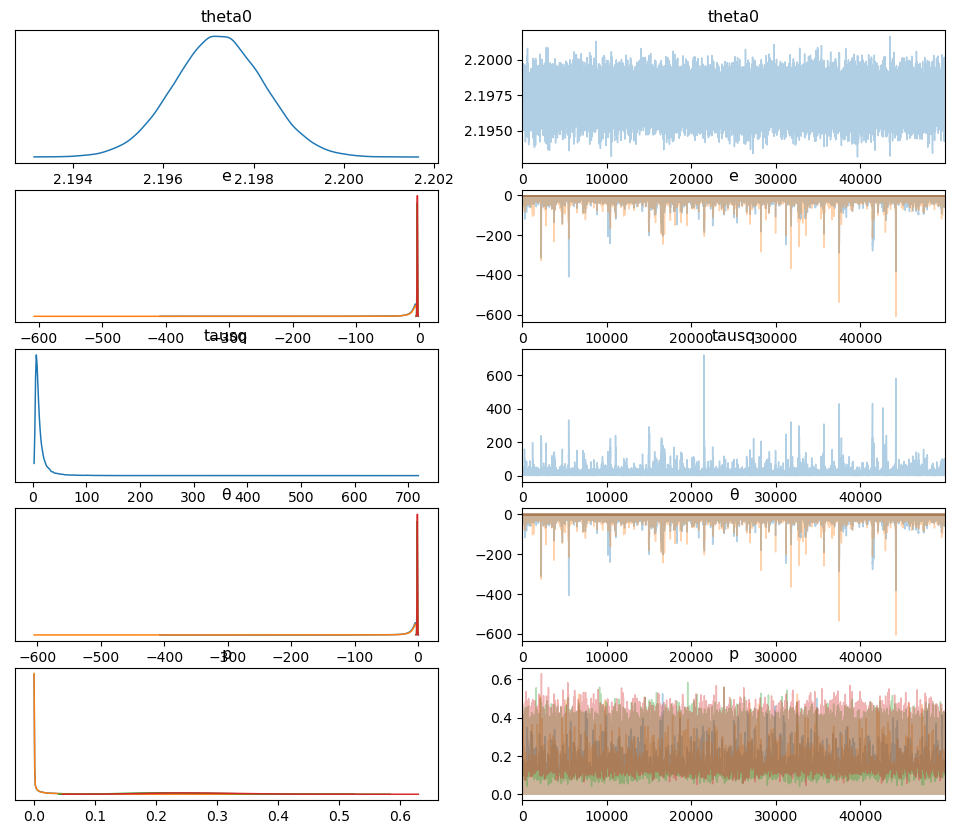

In [41]:
trial.plot_trace(analysis_name, -1)

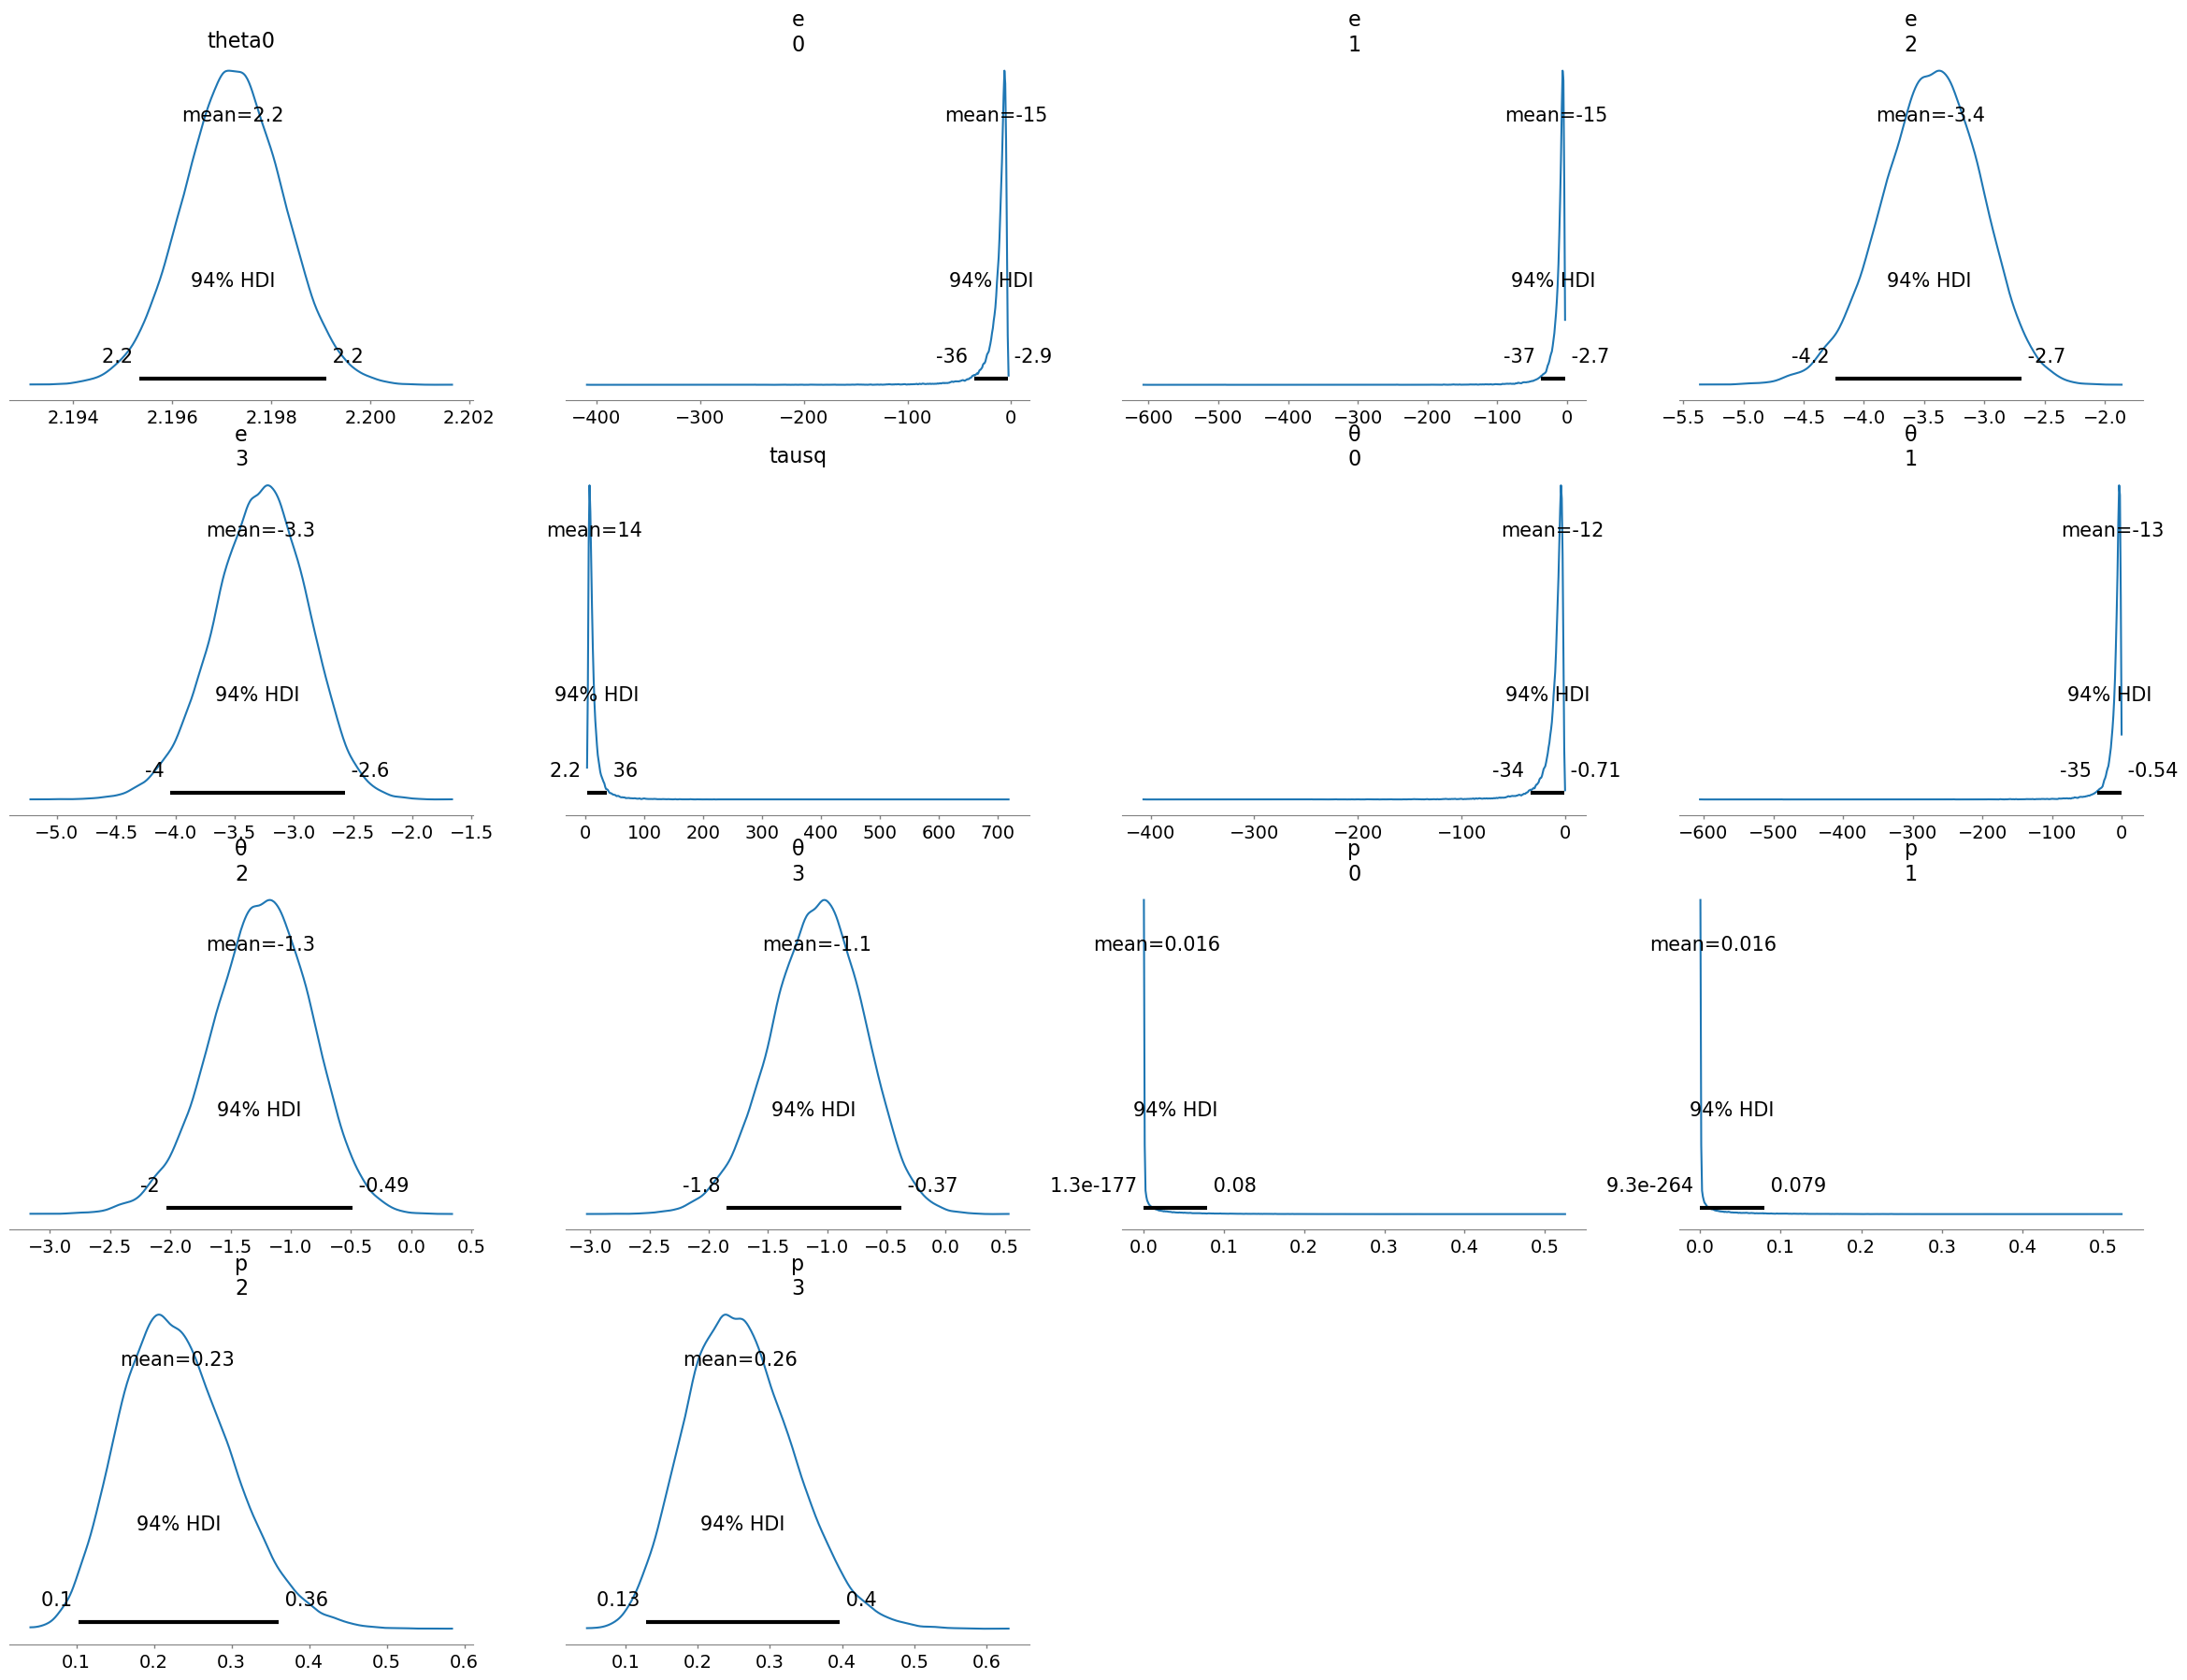

In [42]:
trial.plot_posterior(analysis_name, -1)

In [43]:
trial.final_report(analysis_name)

,status,nnz,total
k,,,
0,EARLY_STOP_FUTILE,0,10
1,EARLY_STOP_FUTILE,0,10
2,COMPLETED_EFFECTIVE,8,35
3,COMPLETED_EFFECTIVE,9,35
